In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import MapModule
from GraphicalUtils import Point,Edge,Graph,Square,Point_Type
from pprint import pprint
import random
import pickle
import os
from SearchingAlgorithems import Dijkstra

## Get full map of Israel
this map will use us to get every sub area in israel and present the points and the flying routes

In [2]:
def get_map():
    full_map= MapModule.get_full_israel_map()
    cropped_map = full_map.crop(Point(34.5,31.7),Point(35,32))
    return  cropped_map


## Get map of Tel Aviv area
from the full Israel map we will crop smaller area of tel aviv

c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<module 'matplotlib.pyplot' from 'c:\\Users\\rongo\\Downloads\\proj\\Nevigation_Algorithems_Project\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

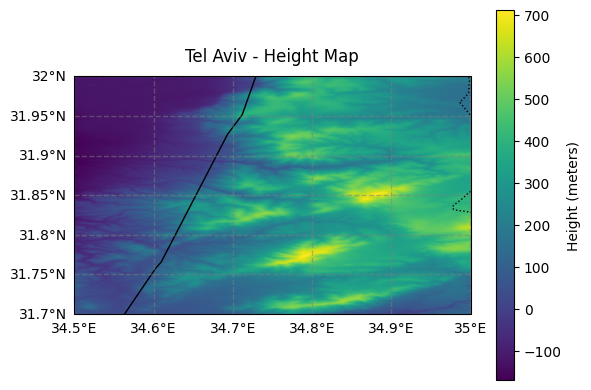

In [3]:
tel_aviv_map:MapModule.Map = get_map()
tel_aviv_map.print()

## Define Pharmecy locations and Costumers location


In the next cell we will define static list of points that represents pharmecies that mark with blue points and static list of static list of yellow points that represent costumers's houses locations

In [4]:
def init_map(map:MapModule.Map,print:bool):
    pharmecy_color = 'blue'
    costumer_color = 'yellow'

    pharmecy_locations = [
    Point(31.9,34.7,color=pharmecy_color,point_type=Point_Type.PHARMECY),
    Point(31.9,34.85,color=pharmecy_color,point_type=Point_Type.PHARMECY),
    Point(31.71,34.73,color=pharmecy_color,point_type=Point_Type.PHARMECY),
    Point(31.812,34.856,color=pharmecy_color,point_type=Point_Type.PHARMECY),
    Point(31.9,34.9,color=pharmecy_color,point_type=Point_Type.PHARMECY)
    
    
    ]

    costumers_locations = [
    Point(31.84,34.7,color=costumer_color,point_type=Point_Type.COSTUMER),
    #Point(31.9,34.85,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.8,34.73,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.754,34.654,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.845,34.767,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.745,34.864,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.922,34.756,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.8,34.87,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.98,34.72,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.97,34.76,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.72,34.96,color=costumer_color,point_type=Point_Type.COSTUMER),
    Point(31.75,34.94,color=costumer_color,point_type=Point_Type.COSTUMER)
    ]

    map.marked_graph.add_points(pharmecy_locations)
    map.marked_graph.add_points(costumers_locations)

    no_fly_zones = [
    Square(Point(32,34.5),Point(31.95,34.7),color=(1,0,0,0.3)),
    Square(Point(31.95,34.5),Point(31.9,34.67),color=(1,0,0,0.3)),
    Square(Point(31.9,34.5),Point(31.85,34.65),color=(1,0,0,0.3)),
    Square(Point(31.85,34.5),Point(31.8,34.62),color=(1,0,0,0.3)),
    Square(Point(31.8,34.5),Point(31.75,34.6),color=(1,0,0,0.3)),
    Square(Point(31.75,34.5),Point(31.7,34.58),color=(1,0,0,0.3)),
    Square(Point(31.887,34.69),Point(31.878,34.715),color=(1,0,0,0.3)),
    #Square(Point(32,34.92),Point(31.7,34.5)),
    Square(Point(31.89,34.78),Point(31.87,34.9),color=(1,0,0,0.3)),
    Square(Point(31.82,34.77),Point(31.7,34.82),color=(1,0,0,0.3)),
    Square(Point(31.82,34.87),Point(31.7,34.92),color=(1,0,0,0.3)),
    Square(Point(31.82,34.66),Point(31.8,34.7),color=(1,0,0,0.3)),
    Square(Point(31.77,34.68),Point(31.7,34.695),color=(1,0,0,0.3)),
    Square(Point(31.82,34.92),Point(31.8,34.96),color=(1,0,0,0.3)),
    Square(Point(31.77,34.95),Point(31.74,35),color=(1,0,0,0.3))
    ]

    map.no_fly_zones.extend(no_fly_zones)

    if(print):
        map.print()




c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


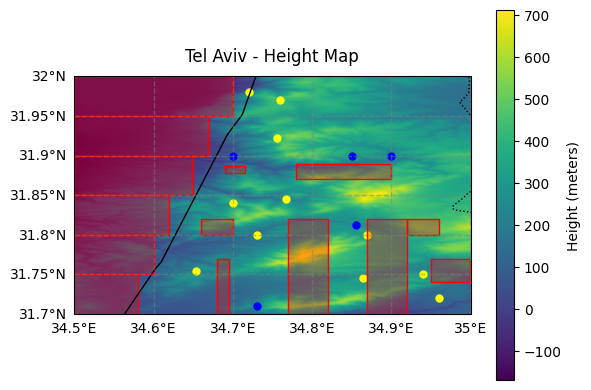

In [5]:
init_map(tel_aviv_map,True)

# Sortest path searching

In the next cells we will try to find the shortest path from costumer to the nearst pharmecy

## PRM

In this section Ill we run the first parts of PRM algoritem.
1) Randomaly generate point over the mao
2) delete every point the located in no flight zone
3) connect all the generated point to each other and creat new edges
4) cennect the generated points to each costumer point and create new ages
5) repeat each step foreach pharmacy
6) deleate each edge that pass over no flight zode

### Randomly genarate N new point over the map 

In [6]:
def generate_N_points(N,map:MapModule.Map) ->list[Point]:
    generated_points: list[Point] = []
    max_y, min_x , min_y, max_x = map.bounds

    for i in range(N):
        rand_x = random.uniform(min_x,max_x)
        rand_y = random.uniform(min_y,max_y)
        generated_points.append(Point(rand_x,rand_y,color='black',size=1))
    return generated_points


In [7]:
def set_z_value_for_points(map:MapModule.Map,points:list[Point]):
    for p in points:
        p.z = map.get_height_at_point(Point(p.y,p.x))
        if(p.type == Point_Type.Regular): p.z = p.z+10

### Delete each point that locatd in no flight zode

In [8]:
def delete_points_from_squers(map:MapModule.Map):
    for zone in map.no_fly_zones:
        pl = []
        for point in map.marked_graph.points:
            if zone.is_inside(point):
                pl.append(point)
                #map.delete_element(point)
        for p in pl:
            map.marked_graph.points.remove(p)

### Conect generated point to each other 

In [9]:
def connect_edges_between_points(points: list[Point],color,thickness = 0.5) -> list[Edge]:
    edges: list[Edge] = []
    for p1 in points:
        for p2 in points:
            if p1 == p2: continue
            if(p1.type == Point_Type.COSTUMER and p2.type == Point_Type.COSTUMER): continue
            if(p1.type == Point_Type.PHARMECY and p2.type == Point_Type.PHARMECY): continue
            edges.append(Edge(p1,p2,color,thickness))
    return edges




### Deleate each edge that cross no fly area

In [10]:
def deleate_all_no_fly_zones_crossing_edges(map:MapModule.Map):
    for zone in map.no_fly_zones:
        el = []
        for edge in map.marked_graph.edges:
            if(zone.is_edge_crossing(edge)):
                el.append(edge)
        for e in el:
            map.marked_graph.edges.remove(e)

def delete_edges_between_costuners(map:MapModule.Map):
    el = []
    for e in map.marked_graph.edges:
        if(e.point1 == Point_Type.COSTUMER and e.point2.type == Point_Type.COSTUMER):
            el.append(e)
        if(e.point1 == Point_Type.PHARMECY and e.point2.type == Point_Type.PHARMECY):
            el.append(e)
    for e in el:
        map.marked_graph.edges.remove(e)


In [11]:
def prm(map:MapModule.Map,N_points:int,print:bool = True):
    generated_points = generate_N_points(N_points,map)
    map.marked_graph.add_points(generated_points)
    set_z_value_for_points(map,map.marked_graph.points)

    if(print): map.print()
    delete_points_from_squers(map)

    if(print): map.print()

    edges_list:list[Edge] = connect_edges_between_points(map.marked_graph.points,'red',0.05)
    map.marked_graph.add_adges(edges_list)

    
    deleate_all_no_fly_zones_crossing_edges(map)
    delete_edges_between_costuners(map)

    ed =[]
    for e in map.marked_graph.edges:
        if(e.length() >= 5):
            ed.append(e)
            map.marked_graph.edges.remove(e)


    if(print): map.print()
    

c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWa

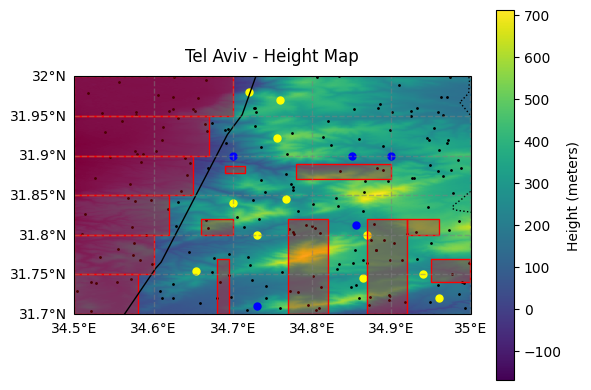

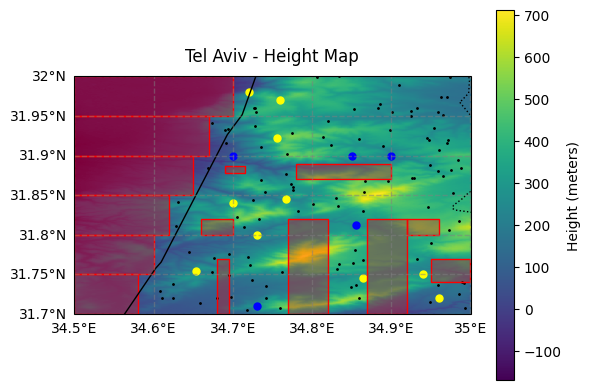

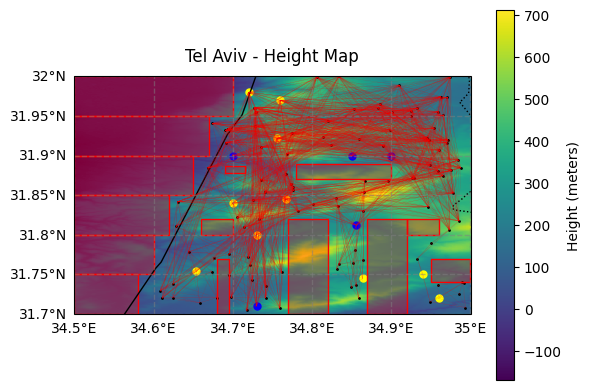

In [12]:
prm(tel_aviv_map,200)

c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<module 'matplotlib.pyplot' from 'c:\\Users\\rongo\\Downloads\\proj\\Nevigation_Algorithems_Project\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

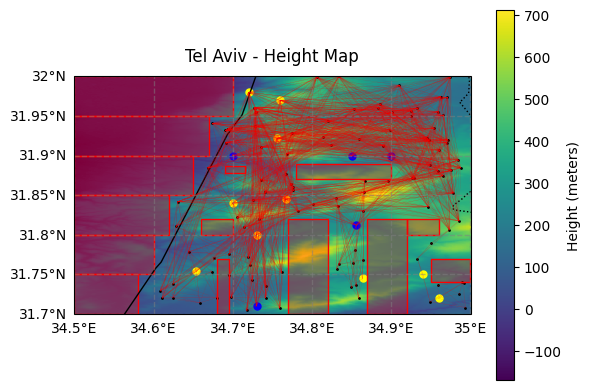

In [13]:
tel_aviv_map.print()

This is out final graph, Now we can move to the second part of finding the sortest path between the points

## Sortest path finding

In this section I will implement 2 grapg searching algorithems, Dijaksta and A*.
then we can compare between them

I Want to find the shortest path for the nearest pharmecy

### Dijakstra

In [14]:
costumers_points = [p for p in tel_aviv_map.marked_graph.points if p.type == Point_Type.COSTUMER]
pharmecy_points = [p for p in tel_aviv_map.marked_graph.points if p.type == Point_Type.PHARMECY]

In [15]:
def get_nearest_pharmecy_per_costumer(map:MapModule.Map,costumers_points:list[Point],pharmecy_points:list[Point]):
    #setup dijakstra algorithem for ant costumer
    algorithems = {point: Dijkstra(map.marked_graph,point) for point in costumers_points}

    nearest_pharmecy = {point: (None,math.inf,[]) for point in costumers_points}
    #run each algorithem
    for costtumer in algorithems:
        algorithems[costtumer].run()

        min_distance = math.inf
        #list of distances to all fharmecy from curren costumer
        for pharmecy in [p for p in algorithems[costtumer].distances if p.type ==Point_Type.PHARMECY]:
            current_cost = algorithems[costtumer].distances[pharmecy]
            if current_cost  < min_distance:
                min_distance = current_cost
                nearest_pharmecy[costtumer] = (pharmecy,current_cost)

    return (nearest_pharmecy,algorithems)
    

           

In [16]:
def mark_path(map,path,color):
    if(path):
            for i,point in enumerate(path):
                
                if(i<len(path)-1):
                    e= map.marked_graph.get_edge(path[i],path[i+1])
                else:
                    e= map.marked_graph.get_edge(path[0],path[i])
                if(e):
                    e.color = color
                    e.thickness=2
                    e.is_part_of_path=True


                #cropped_map.marked_graph.points.remove(point)
                point.size = 50
                if(point.type == Point_Type.Regular):
                    point.color = color


In [17]:
def add_routes_to_map(map:MapModule.Map,costumers_points:list[Point],nearest_pharmecy,algorithems):
    path_colors = ['black','red','gray','brown','white','green','pink',(0.5,0.3,0.9),(0.8,0.4,0.6),(0.6,0.46,0.3),(0.1,0.4,0.6)]
    for c, costtumer in enumerate(costumers_points):
        nearest_pharm = nearest_pharmecy[costtumer][0]
        path = algorithems[costtumer].get_shortest_path(nearest_pharm)
        
        mark_path(map,path,path_colors[c])


In [18]:
nearest_pharmesies, algorithems_data = get_nearest_pharmecy_per_costumer(tel_aviv_map,costumers_points,pharmecy_points)

shortest_path_to_ant_pharmecy_djakstra = {costumer : 0 for costumer in costumers_points}
for c in costumers_points:
    shortest_path_to_ant_pharmecy_djakstra[c] = nearest_pharmesies[c][1]

In [19]:
add_routes_to_map(tel_aviv_map,costumers_points,nearest_pharmesies,algorithems_data)

c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<module 'matplotlib.pyplot' from 'c:\\Users\\rongo\\Downloads\\proj\\Nevigation_Algorithems_Project\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

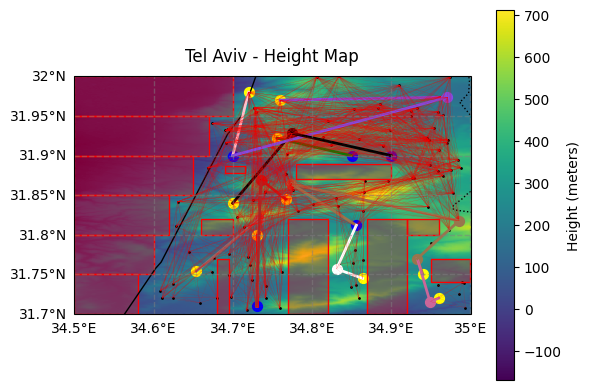

In [20]:
tel_aviv_map.print()

### To make the map clearer I remove all the other edges

In [21]:
def remove_unused_edges(map:MapModule.Map):
    el = []
    for edge in map.marked_graph.edges:
        if not edge.is_part_of_path:
            el.append(edge)    

    for e in el:
        map.marked_graph.edges.remove(e)

In [22]:
remove_unused_edges(tel_aviv_map)

c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<module 'matplotlib.pyplot' from 'c:\\Users\\rongo\\Downloads\\proj\\Nevigation_Algorithems_Project\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

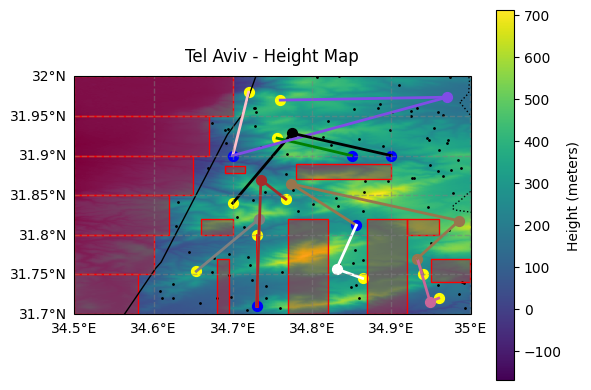

In [23]:
tel_aviv_map.print()

# A*

In [24]:
from heapq import heappop, heappush
from abc import ABC, abstractmethod

from GraphicalUtils import Point

class Node:
    def __init__(self, parent=None, position:Point=None):
        self.parent = parent
        self.position = position

        self.g = 0  # Distance to start node
        self.h = 0  # Distance to goal node
        self.f = 0  # Total cost

    def __eq__(self, other):
        return self.position == other.position

    def __lt__(self, other):
        return self.f < other.f
    
class A_Star(ABC):

    def __init__(self,start:Point,end:Point) -> None:
        self.start_node = Node(None,start)
        self.end_node = Node(None,end)
        self.path :list[Point] = None

        # Initialize open and closed lists
        self.open_list = []
        self.closed_set = []

        self.cost = None

        heappush(self.open_list, self.start_node)

    @abstractmethod
    def child_function(self,node:Node):
        pass

    @abstractmethod
    def get_point(self,node: Node):
        pass

    def run(self):
        while self.open_list:
            current_node:Node= heappop(self.open_list)
            self.closed_set.append(current_node)

            if current_node == self.end_node:
                path = []
                self.cost = 0
                self.cost = current_node.g
                while current_node:
                    path.append(current_node.position)
                    current_node = current_node.parent
                self.path =  path[::-1]  # Return reversed path
                return
            

            children = self.child_function(current_node)
            # Loop through children
            for child in children:
                # Child is on the closed list
                if child in self.closed_set:
                    continue

                # Create the f, g, and h values
                child.g = current_node.g + Edge(current_node.position,child.position).length()

                child_point = self.get_point(child)
                end_point = self.get_point(self.end_node)
            

                child.h = Edge(child_point,end_point).length()
                child.f = child.g + child.h

                # Child is already in the open list
                if child not in self.open_list:
                    # Add the child to the open list
                    heappush(self.open_list, child)

                 # No path found
        self.path =  None



class A_STAR_Graph(A_Star):
    def __init__(self, graph: Graph, start: Point, end: Point) -> None:
        super().__init__(start, end)
        self.graph:Graph = graph

    def child_function(self,node: Node):
        neighbors_edges = self.graph.get_point_neighbors(node.position)
        neighbors_nodes = []
        for n in neighbors_edges:
            neighbors_nodes.append(Node(node,n.point2))
        return neighbors_nodes
    
    def get_point(self, node: Node):
        return node.position


class A_STAR_Maze(A_Star):

    def __init__(self, maze: list[list[Point]], start: Point, end: Point) -> None:
        super().__init__(start, end)
        self.maze = maze


    def child_function(self,current_node:Node):
        # Generate children
        children:list[Node] = []
        for new_position in [(0, -1),(0, 1), (-1, 0), (1, 0)]:  # Adjacent squares
            # Get node position

            node_position = Point(current_node.position.x + new_position[0],current_node.position.y + new_position[1])

            # Make sure within range
            if node_position.x > (len(self.maze) - 1) or node_position.x < 0 or node_position.y > (len(self.maze[len(self.maze)-1]) -1) or node_position.y < 0:
                continue

            # Make sure walkable terrain
            if self.maze[node_position.x][node_position.y].z == np.nan:
                continue

            # Create new node
            new_node = Node(current_node, node_position)
            # Append
            children.append(new_node)
        return children
    
    def get_point(self,node: Node):
        self.maze[node.position.x][node.position.y]


In [25]:
tel_aviv_map = get_map()

In [26]:
tel_aviv_map.marked_graph.points = []
tel_aviv_map.marked_graph.edges = []
init_map(tel_aviv_map,False)

c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<module 'matplotlib.pyplot' from 'c:\\Users\\rongo\\Downloads\\proj\\Nevigation_Algorithems_Project\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

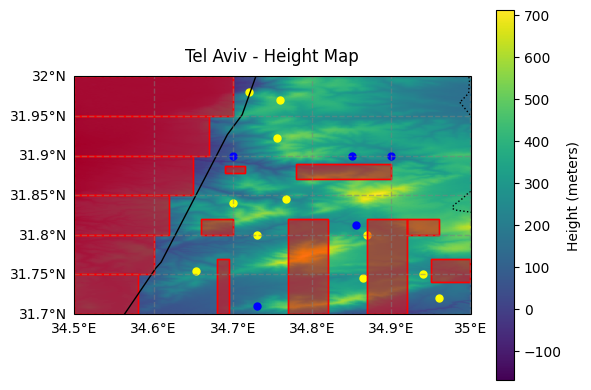

In [27]:
tel_aviv_map.print()

In [28]:
prm(tel_aviv_map,200,False)
#tel_aviv_map.print()

In [29]:
costumers_points = [p for p in tel_aviv_map.marked_graph.points if p.type == Point_Type.COSTUMER]
pharmecy_points = [p for p in tel_aviv_map.marked_graph.points if p.type == Point_Type.PHARMECY]
path_colors = ['black','red','gray','brown','white','green','pink',(0.5,0.3,0.9),(0.8,0.4,0.6),(0.6,0.46,0.3),(0.1,0.4,0.6)]
shortest_path_to_ant_pharmecy_A_STAR_G = {c: 0 for c in costumers_points}

for i,c in enumerate(costumers_points):
    nearest_pharmecy_path = []
    nearest_pharm = None
    nearest_pharm_dist = np.inf

    for p in pharmecy_points:
        a_star_g = A_STAR_Graph(tel_aviv_map.marked_graph,c,p)
        a_star_g.run()

        if(a_star_g.cost < nearest_pharm_dist):
            nearest_pharm = p
            nearest_pharm_dist = a_star_g.cost
            nearest_pharmecy_path = a_star_g.path

    shortest_path_to_ant_pharmecy_A_STAR_G[c] = a_star_g.cost
    mark_path(tel_aviv_map,nearest_pharmecy_path,path_colors[i])
remove_unused_edges(tel_aviv_map)


c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\rongo\Downloads\proj\Nevigation_Algorithems_Project\.venv\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<module 'matplotlib.pyplot' from 'c:\\Users\\rongo\\Downloads\\proj\\Nevigation_Algorithems_Project\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

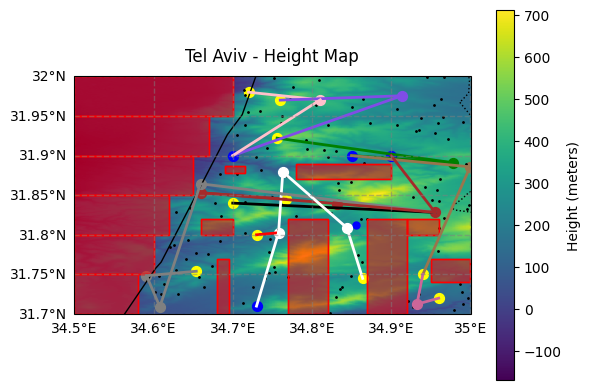

In [30]:
tel_aviv_map.print()

# comperation

In [31]:
d_shrwsets_path_list = list(shortest_path_to_ant_pharmecy_djakstra.items())
a_shrwsets_path_list = list(shortest_path_to_ant_pharmecy_A_STAR_G.items())

for i,item in enumerate(d_shrwsets_path_list):
    print(f'Costumer location: {str(item[0])}, Djakstra cost: {item[1]} , A* Cost: {a_shrwsets_path_list[i][1]}')

Costumer location: (31.84,34.7,216), Djakstra cost: 36.00092520158821 , A* Cost: 46.00161926292421
Costumer location: (31.8,34.73,400), Djakstra cost: 49.000082652991516 , A* Cost: 148.00101899970855
Costumer location: (31.754,34.654,267), Djakstra cost: 84.00029656472381 , A* Cost: 27.020439761266147
Costumer location: (31.845,34.767,281), Djakstra cost: 70.00425638241092 , A* Cost: 29.11668686713965
Costumer location: (31.745,34.864,343), Djakstra cost: 214.00008558331893 , A* Cost: 91.0014194554295
Costumer location: (31.922,34.756,123), Djakstra cost: 43.00010837195646 , A* Cost: 129.0001534047081
Costumer location: (31.98,34.72,-110), Djakstra cost: 151.00002251655462 , A* Cost: 362.00005359115625
Costumer location: (31.97,34.76,34), Djakstra cost: 7.017272231045627 , A* Cost: 218.00005619265332
Costumer location: (31.72,34.96,141), Djakstra cost: 400.00270797812504 , A* Cost: 619.0000955358519
Costumer location: (31.75,34.94,346), Djakstra cost: 195.00270601187935 , A* Cost: 414.

# MAZE


In [33]:
def float_range(start, stop, step):
    while start < stop:
        f_points = math.ceil(-math.log(step,10))
        yield round(start, f_points)  # rounding to two decimal places
        start += step

def convert_map_to_maze(map:MapModule.Map) -> list[list[Point]]:
    maze = []
    step = 0.1
    for x,i in  enumerate(float_range(map.bounds[1],map.bounds[3]-step,step)):
        line = []
        for y,j in enumerate(float_range(map.bounds[2],map.bounds[0]-step,step)):
            if any(zone.is_inside(Point(i,j)) for zone in map.no_fly_zones):
                line.append(Point(i,j,np.nan))
            else:
                line.append(Point(i,j,map.get_height_at_point(Point(j,i))))
        
        maze.append(line)

    return maze[::-1]
            

In [34]:
maze:list[list[Point]] = convert_map_to_maze(tel_aviv_map)


In [35]:
def get_maze_index_of_point(maze:list[list[Point]],point:Point):
    a,b =0,0
    step = maze[0][1].y - maze[0][0].y
    step = round(step,5)
    step = math.ceil(-math.log(step,10))

    for i,l in enumerate(maze):
        for j,c in enumerate(l):
            rount_point = Point(round(point.y,step),round(point.x,step))
            if(round(maze[i][j].x,step) == rount_point.y and round(maze[i][j].y,step) == rount_point.x):
                return Point(b,a)
            a = a+1
        a =0
        b = b+1


: 